In [1]:
from sklearn.model_selection import train_test_split as tts
from sklearn import svm
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler,normalize
from torch.autograd import Variable
from scipy import stats
import umap

In [2]:
class CustomTextDataset(Dataset):
    def __init__(self, X, Y):
        self.labels = Y.disease_type.values
        self.sample = X
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.sample[idx]
        return text, label

In [9]:
class VAE(nn.Module):
    def __init__(self, hiddenSize = 100, input_size = 5000):
        super(VAE, self).__init__()
        self.hiddenSize = hiddenSize
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.LayerNorm(100, 1e-3),
            nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(self.hiddenSize, 100),
            nn.LayerNorm(100),
             nn.ReLU(),
            nn.Linear(100, input_size),
            )
        self.mu = torch.nn.Linear(100, self.hiddenSize)
        self.logvar = torch.nn.Linear(100, self.hiddenSize)
        self.s1 = nn.Sigmoid()

    def reparametrize(self, h):
        mu = self.mu(h)
        logvar = self.logvar(h)
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu), mu, logvar

    def forward(self, x):
        h1 = self.encoder[1](self.encoder[0](x))
        h = self.encoder[3](self.encoder[2](h1))
        z, mu, logvar = self.reparametrize(h)
        decoded = self.decoder(z)
        return self.s1(decoded), mu, logvar, z, h1
    
    def generate_sample(self):
        z = torch.FloatTensor(self.hiddenSize).normal_()
        return self.decoder(z)

In [4]:
# reconstruction_function = nn.BCELoss()
def reconstruction_function(x_output, y_target):
    """
    autoencoder_loss
    This implementation is equivalent to the following:
    torch.nn.BCELoss(reduction='sum') / batch_size
    As our matrix is too sparse, first we will take a sum over the features and then do the mean over the batch.
    WARNING: This is NOT equivalent to torch.nn.BCELoss(reduction='mean') as the later on, mean over both features and batches.
    """
    epsilon = 1e-10
    term = y_target * torch.log(x_output + epsilon) + (1. - y_target) * torch.log(1. - x_output + epsilon)
    loss = torch.mean(-torch.sum(term, 1), 0)
    return loss
    
def loss_function(recon_x, x, mu, logvar):
    """
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar) # KL(q(z|x)||p(z))
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return BCE + KLD


In [5]:
import os
idx = []
groundTruth = []
meta = pd.read_csv('../TCGA_data/metadata/q4_metadata.csv')
for file in os.listdir('../TCGA_data/clean'):
    if file in list(meta['filename']):
        idx.append(True)
        groundTruth.append(file)
    else:
        idx.append(False)


In [43]:
meta = pd.read_csv('../TCGA_data/metadata/q1_metadata.csv')
ordered_ys = []
for file in os.listdir('../TCGA_data/clean'):
    ordered_ys.append(meta[meta['filename'] == file])
ordered_ys = pd.concat(ordered_ys)

In [6]:
X = pd.read_csv('../TCGA_data/processing/top10k_abs_dev.csv', index_col = 'gene_id')
X = X.iloc[:, list(idx)]
Y = pd.read_csv('../TCGA_data/processing/ordered_ys.csv')
#Y = ordered_ys
X.columns = Y.id
X = X.T
Xf = X

In [7]:
#Log transform - variance collapse
X = np.log(X.values+1)


In [8]:
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)

In [101]:
#lung = Y[Y['disease_type'] == 'Adenomas and Adenocarcinomas']
#lung_X = np.take(X, lung.index, axis = 0)
#X = lung_X
#Y = lung

In [10]:
tcga = CustomTextDataset(X,Y)
TCGA_loader = DataLoader(tcga, batch_size=64, shuffle=True)
#valid_data = CustomTextDataset(X, Y)
#valid_loader = Dataloader()

In [ ]:
V = 

In [11]:
run_name = "VAE_tumor_only_3lyr"
num_genes = 10000
num_epochs = 50
learning_rate = 3e-4
batch_size = 64
model_VAE = VAE(hiddenSize = 100, input_size = num_genes)
model_VAE.cuda()
optimizer = torch.optim.Adam(model_VAE.parameters(), lr = learning_rate)
architecture = [('in', 100), (100, 100), (100, 100), (100, 'hidden')]
hidden_size = 100

In [113]:
"""

wandb.init(project = "TCGA_transcriptomes", name = run_name)
wandb.config = {
    "learning_rate": learning_rate,
    "num_genes": num_genes,
    "cancer_types": "all",
    "hidden_size": hidden_size,
    "architecture": architecture,
    "epochs": num_epochs,
    "batch_size": batch_size
}
"""

loss,█▇▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▇▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,6466.58954
mse,0.00445


In [12]:
epoch_train_loss = []
epoch_train_mse = []
for epoch in range(num_epochs):
    model_VAE.train()
    lossList = []
    mseList = []
    for i, data in enumerate(TCGA_loader):
        optimizer.zero_grad()
        inputData = data[0].float()
        inputData = inputData.cuda()
        recon_batch, mu, logvar, encoded, h1 = model_VAE(inputData)
        loss = loss_function(recon_batch, inputData, mu, logvar)
        loss.backward()
        optimizer.step()
        mse = nn.functional.mse_loss(recon_batch, inputData)
        
        lossList.append(loss.item())
        mseList.append(mse.item())
        
    epochLoss = np.mean(lossList)
    #wandb.log({"loss": epochLoss})
    epoch_train_loss.append(epochLoss)
    epochMse = np.mean(mseList)
    epoch_train_mse.append(epochMse)
    #wandb.log({"mse": epochMse})
    print('Epoch: ', epoch, '| train loss: %.4f' % epochLoss, 'MSE: ', epochMse)
#torch.save(model_VAE.state_dict(), '/home/clj248/zitnik_lab/users/clj248/vanilla_AE/VAE_checkpoints/tumor_only_10k_3lyr')

IndexError: index 3 is out of range

Text(0.5, 0, 'epoch')

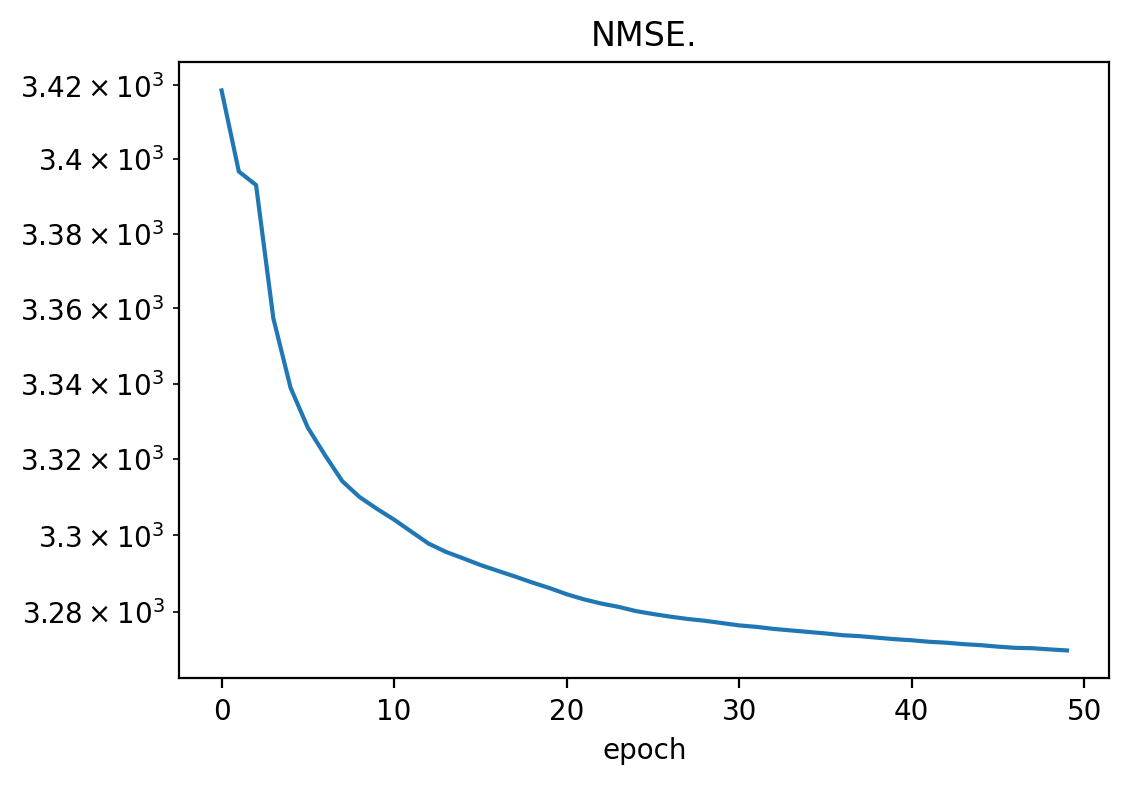

In [33]:
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(1,1,1)
ax.semilogy(epoch_train_loss)
ax.set_title('NMSE.')
ax.set_xlabel('epoch')

In [40]:
import seaborn as sns
import os, umap
za = []
# def plot_latent(autoencoder, data, num_batches=100):
yl = []
model_VAE.eval()
for i, data in enumerate(TCGA_loader):
    inputData = data[0].float()
    
    inputData = inputData.cuda()
    b = inputData.shape[0]
    recon_batch, mu, logvar, encoded, h1= model_VAE(inputData)

    za.append(encoded.reshape(b, -1).cpu().detach().numpy())
    yl.append(data[1])
za = np.vstack(za)

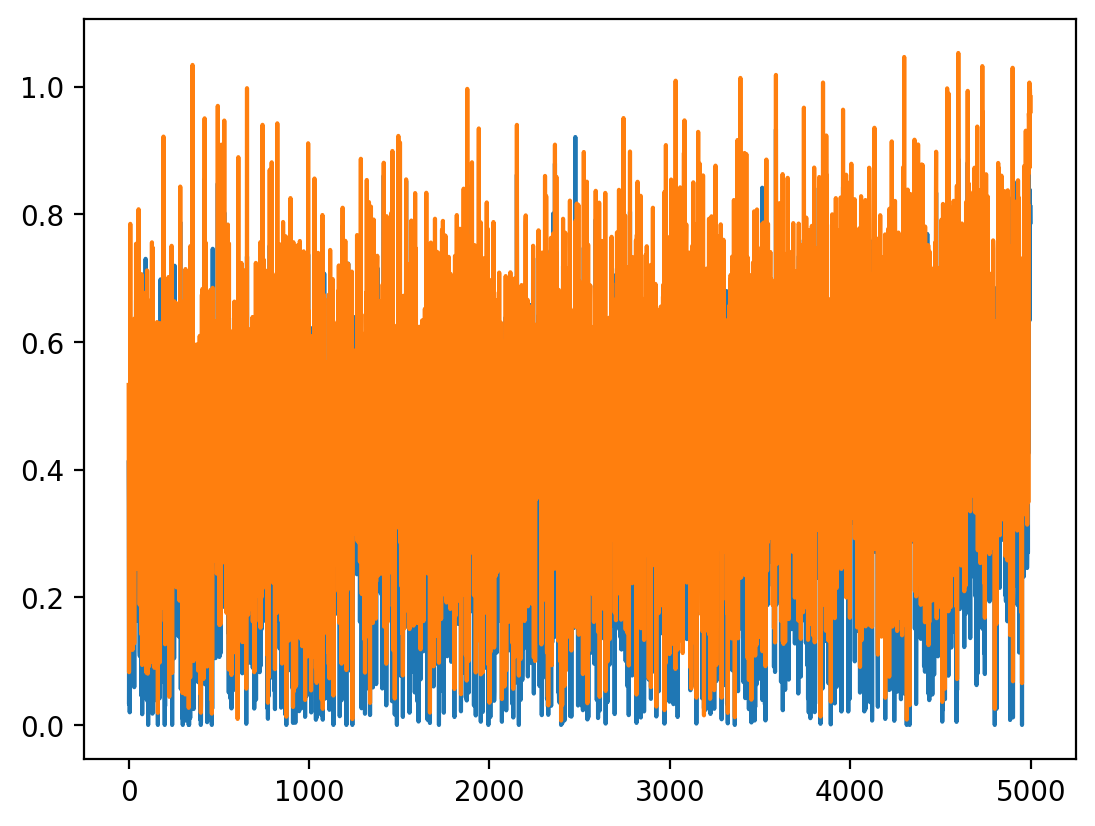

In [35]:
plt.plot(inputData[0].cpu())
plt.plot(recon_batch[0].cpu().detach().numpy()*1.2)

In [41]:
brain_umap = umap.UMAP(random_state=999, n_neighbors=32, min_dist=1)
embedding = pd.DataFrame(brain_umap.fit_transform(za), columns = ['UMAP1','UMAP2'])
y = Y

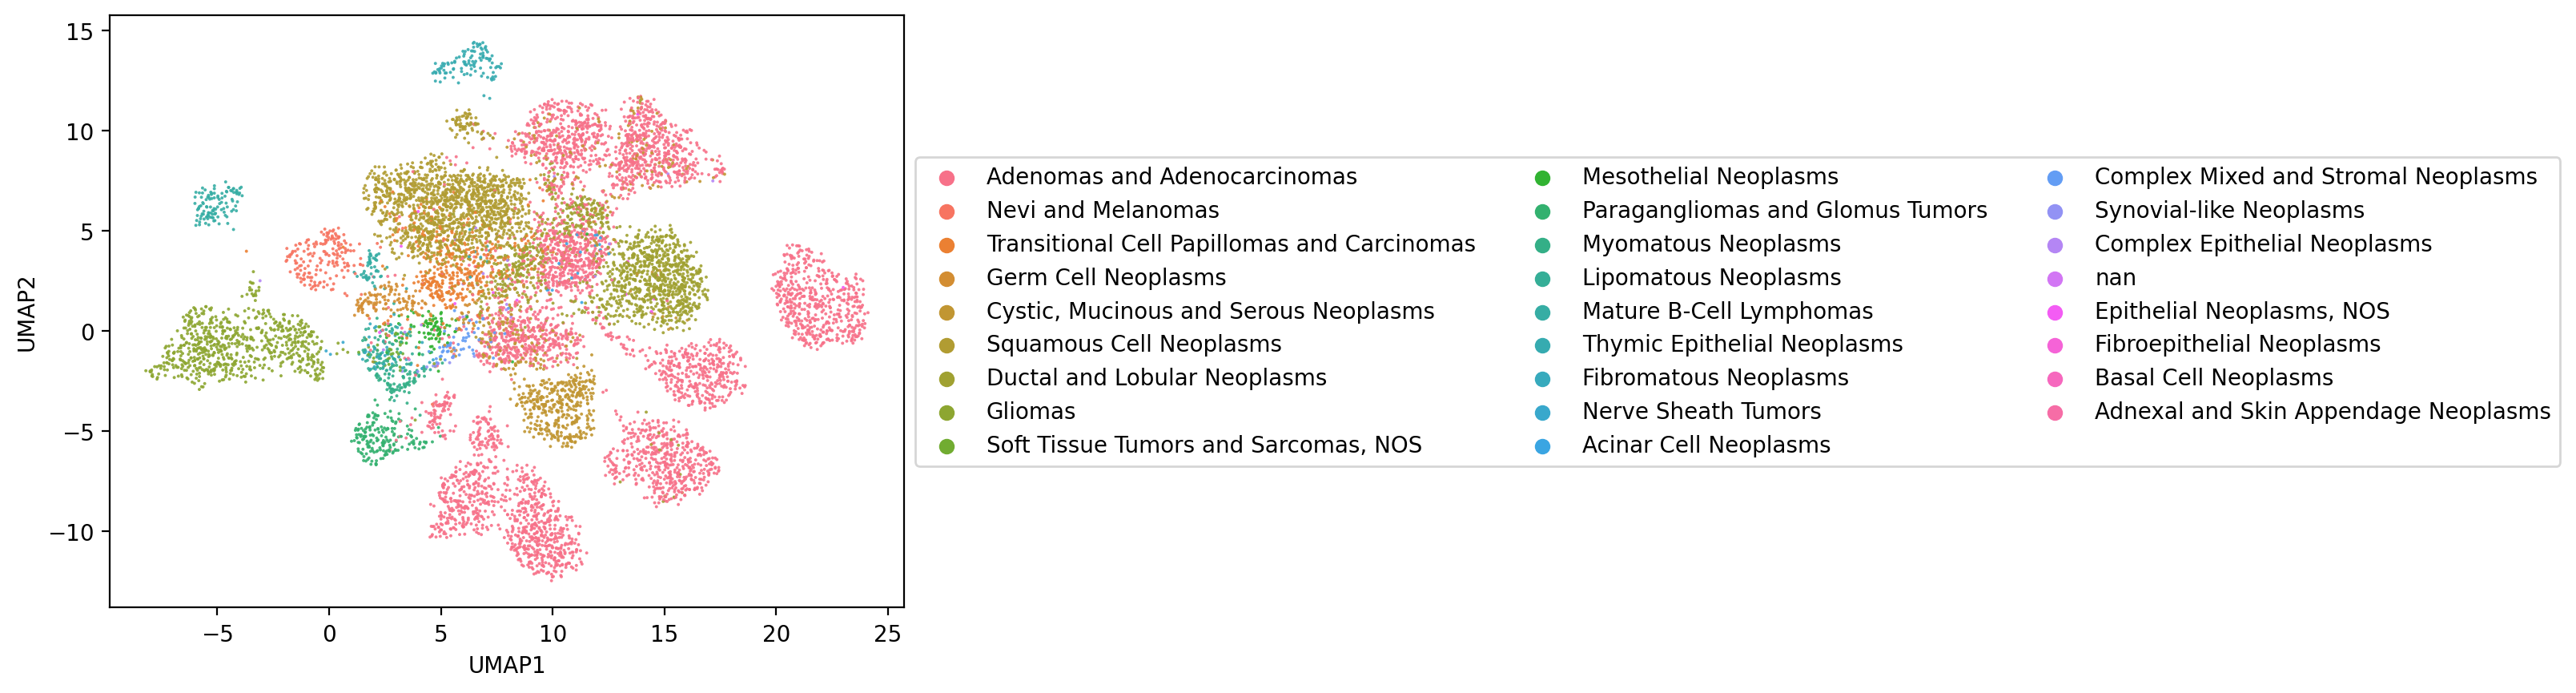

In [42]:
sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding,
                hue=np.concatenate(yl),
                alpha=.9, linewidth=0, s=2)
# Adjust legend
sns_plot.legend(ncol=3, loc='center left', bbox_to_anchor=(1, .5))
# Save PNG
sns_plot.figure.savefig('umap_scatter.png', bbox_inches='tight', dpi=500)